# Reverse Diffusion

In [1]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import math

from diffusion.schedules import beta_schedule
from diffusion.forward import compute_alphas, q_sample
from diffusion.reverse import p_sample
from diffusion.utils.visualization import tensor2image

In [2]:
path = "../assets/sample.jpeg"
img = Image.open(path).convert("RGB")

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

x0 = transform(img)

In [3]:
T_steps = 42
betas = beta_schedule(T_steps)
alphas, alphas_bar = compute_alphas(betas)

In [4]:
noisy_imgs = []
epsilons = [] #to store the noise used at each t

for t in range(T_steps):
    eps = torch.randn_like(x0)
    epsilons.append(eps)

    sqrt_ab = torch.sqrt(alphas_bar[t])
    sqrt_one_minus = torch.sqrt(1 - alphas_bar[t])

    xt = sqrt_ab * x0 + sqrt_one_minus * eps
    noisy_imgs.append(xt)


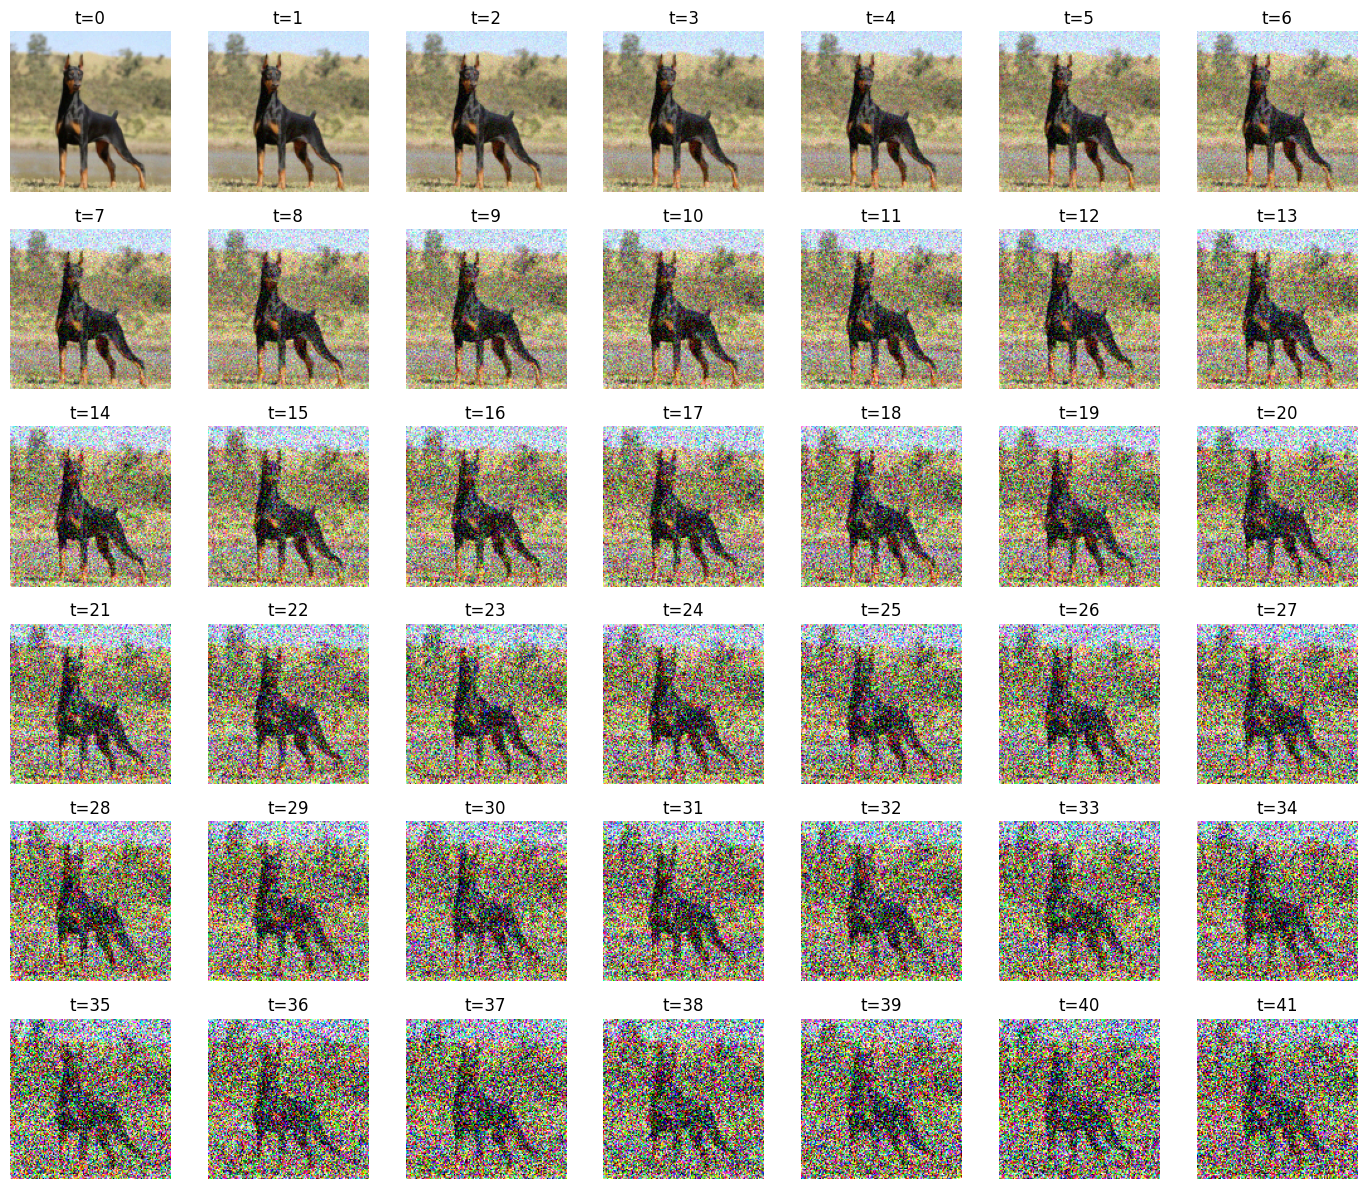

In [5]:
cols = math.ceil(math.sqrt(T_steps))
rows = math.ceil(T_steps / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for ax, img_t, step in zip(axes.flatten(), noisy_imgs, range(T_steps)):
    ax.imshow(tensor2image(img_t))
    ax.set_title(f"t={step}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
xt = noisy_imgs[-1]   # x_T is the noisiest image
reverse_imgs = [xt]

for t in reversed(range(T_steps)):
    eps = epsilons[t]
    xt = p_sample(xt, t, eps, betas, alphas, alphas_bar)
    reverse_imgs.append(xt)


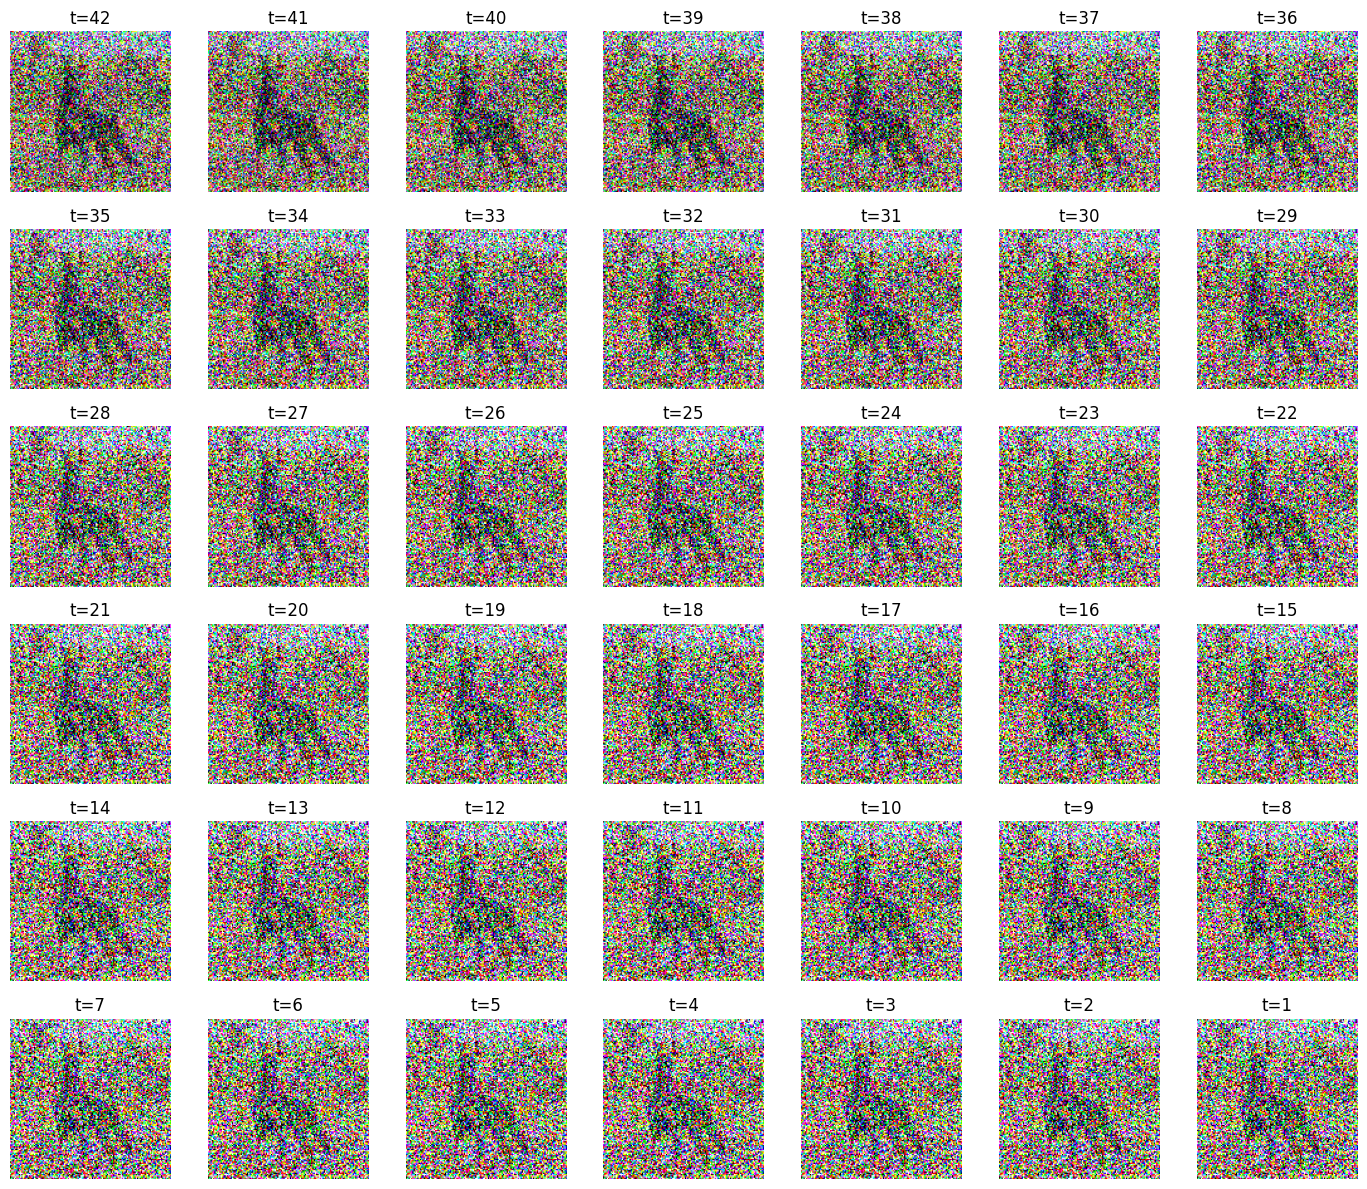

In [7]:
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for ax, img_t, step in zip(axes.flatten(), reverse_imgs, reversed(range(T_steps+1))):
    ax.imshow(tensor2image(img_t))
    ax.set_title(f"t={step}")
    ax.axis("off")

plt.tight_layout()
plt.show()

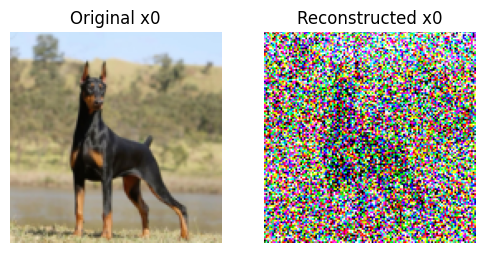

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(tensor2image(x0))
ax1.set_title("Original x0")
ax1.axis("off")

ax2.imshow(tensor2image(reverse_imgs[-1]))
ax2.set_title("Reconstructed x0")
ax2.axis("off")

plt.show()

In [ ]:
diff = (x0 - reverse_imgs[-1]).abs().mean()
diff

tensor(0.8117)

## Why It Cannot Recover the Image

In the forward process of DDPM, the image $x_0$ is progressively corrupted by adding Gaussian noise. This process destroys visual information as $t$ increases. In a trained DDPM model, the reverse step is implemented as:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

where $\epsilon_\theta$ is a neural network that predicts the noise that was added during the forward process.

* $x_{t-1}$: The denoised sample at the previous timestep, which is being generated.
* $x_t$: The current noisy sample at timestep $t$.
* $\alpha_t$: The variance schedule parameter (usually $\alpha_t = 1 - \beta_t$).
* $\bar{\alpha}_t$: The cumulative product of $\alpha$ up to time $t$, defined as $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$.
* $\epsilon_\theta(x_t, t)$: A neural network (often a U-Net) that is trained to predict the noise component ($\epsilon$) in $x_t$. The $\theta$ indicates the learnable parameters of the network.
* $\sigma_t z$: The stochastic noise added during the reverse step, where $\sigma_t$ is the standard deviation and $z \sim \mathcal{N}(0, I)$ is a standard Gaussian sample.

However, in this notebook i'm gonna intentionally run the reverse process without a trained network. Instead, we use the true forward noise:

<div style="text-align: center;">
    <pre>
    x0_pred = predict(xt, T, eps, alphas_bar)
    </pre>
</div>

Even though this is mathematically correct, it cannot reconstruct the original image because i'm not using a model that has learned how to predict the noise. The reverse step is therefore “blind”, it applies the correct equations, but it has no knowledge of the structure of the underlying image.